In [ ]:
%matplotlib inline
%time from hikyuu.interactive import *

#  1 绘制指标

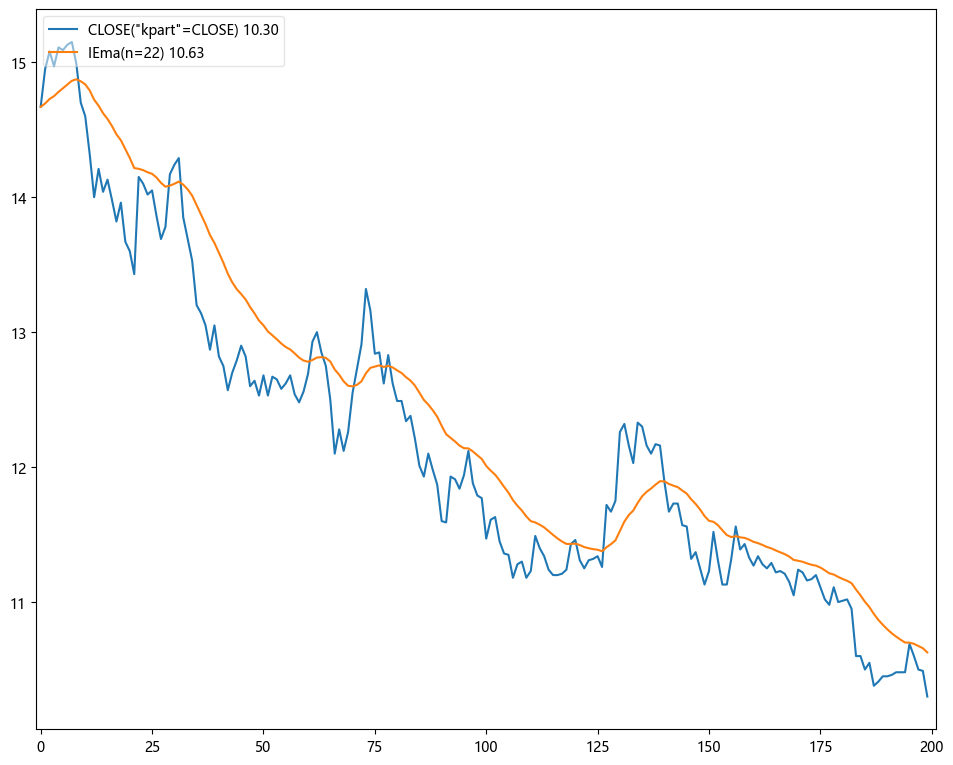

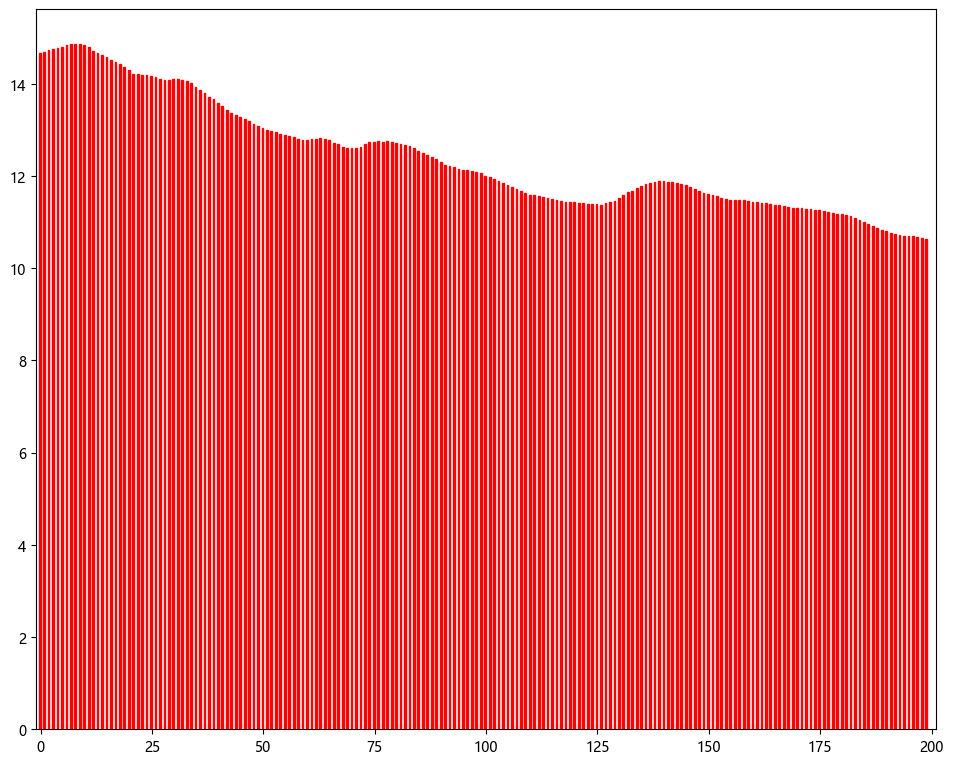

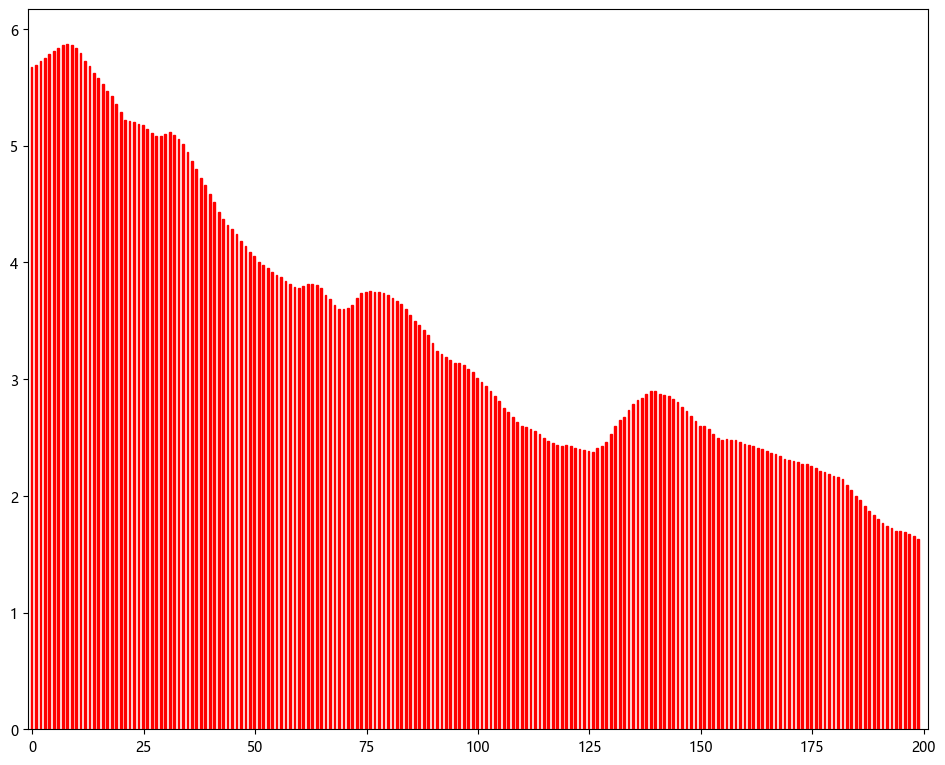

In [33]:
s = sm['sz000001']
k = s.get_kdata(Query(-200))


# 抽取K线收盘价指标，一般指标计算参数只能是指标类型，所以必须先将K线数据生成指标类型
c = CLOSE(k)

# 计算收盘价的EMA指标
a = EMA(c)

# 绘制指标
c.plot(legend_on=True)
a.plot(new=False, legend_on=True)

# 绘制柱状图
a.bar()

# 修正下柱状图，使其更美观
PRICELIST([x-9 for x in a]).bar()

# 2 指标（Indicator）

在 Hikyuu 中，Indicator 的实例是用于计算的主要数据结构，一般 ind（如无说明，ind代表Indicator的实例）计算的参数为另一个ind，如EMA(x),x应是一个Indicator的实例。可以简单的理解为类似 numpy.array。

## 2.1 特殊的Indicator

其中存在一类特殊的Indicator，用于将K线数据或普通数组转换为ind，才能供其他ind进行计算，如 KDATA 将 KData 转化为一个ind。其他包括: OPEN,HIGH,LOW,CLOSE,AMO(成交金额),VOL(成交量),KDATA_PART。

In [ ]:
print("k is a instance of KData:\n", k)
print("--------------------------\n")

kind = KDATA(k)
print("kind is a instance of Indicator:\n", kind)

In [ ]:
#获取 ind 的结果集数量，如MACD通常返回3个结果集
r = kind.get_result_num()
print("result_num: ", r)

#获取第一个结果集
x = kind.get_result(0)
print(x)

In [ ]:
#以下效果相同
c1 = CLOSE(k)
c2 = KDATA_PART(k, 'close')

另外一个常用的特殊指标 PRICELIST将 Python 中的类 list 对象包装成ind。

In [ ]:
x = PRICELIST([i for i in range(100)])
print(len(x), x)

## 2.2 Indicator的特性与参数

每一个指标函数，如EMA、HHV，调用后生成一个ind对象，该对象本身可以再次调用生成新的ind。无论指标函数还是 ind 对象调用生成 ind，都是立刻进行计算。

In [ ]:
e1 = EMA(CLOSE(k), n=5)
e2 = e1(CLOSE(k))
e3 = e2
print(e1 == e2)

除在指标函数中指定参数外，可以通过 getParam、setParam 方法来获取和修改 ind 对象的参数。修改参数后，ind 本身并不会发生变化，需要调用生成新的 ind，新的 ind 才是使用新参数计算的结果。

In [ ]:
e = EMA(c)
print(e)
print(e.get_param('n'))
e.plot(legend_on=True)

e.set_param('n', 30)
e = e(c)
e.plot(new=False, legend_on=True)

查看 ind 参数。ind 参数支持：

- i : int
- s : str
- b : bool
- d : float

In [ ]:
#EMA指标有参数 "n"，类型"i"代表整数
print(EMA())

## 2.3 TA-Lib包装指标

在交互工具里对TA-Lib进行了包装，命名方式统一为 TA_FUNC名称。其中，ta-lib指标的lookback属性，用discard属性代替。

In [ ]:
x = TA_SMA(CLOSE(k))
print(x)
x.plot()

print(x.discard)

个别的Ta-Lib函数需要两个数组参数，比如BETA、CORREL。此时需要利用特殊的 Indicator  WEAVE 将两个数组包装到一个 ind 对象中。

In [ ]:
query = Query(-200)
k1 = sm['sh000001'].get_kdata(query)
k2 = sm['sz000001'].get_kdata(query)

w = WEAVE(CLOSE(k1), CLOSE(k2))
print(w.get_result_num())

cr = TA_CORREL(w)
cr.plot()

## 2.4 动态指标参数

在通道信等证券行情软件中，其技术指标中的窗口参数通常支持整数，也支持使用指标，如：

```
T1:=HHVBARS(H,120); {120内的最高点距今天的天数}
L120:=LLV(L,T1+1); {120内的最高点至今，这个区间的最低点}
```

***自 1.2.3 版本后，Hikyuu 也开始支持使用指标作为窗口参数***

In [ ]:
h = HIGH(k)
l = LOW(k)
T1 = HHVBARS(h, 120)
L120 = LLV(l, T1+1)
L120.plot()

**注意事项**

由于无法区分 Indicator(ind) 形式时，ind 究竟是指标参数还是待计算的输出数据，此时如果希望 ind 作为参数，需要通过 IndParam 进行显示指定，如：EMA(IndParam(ind))。

最佳的方式，则是通过指定参数名，来明确说明使用的是参数：

```
x = EMA(c)  # 以收盘价作为计算的输入
y = EMA(IndParam(c)) # 以收盘价作为 n 参数
z = EMA(n=c) # 以收盘价作为参数 n
```

In [ ]:
# 或者以原型的方式，通过指定上下文计算
T1 = HHVBARS(H, 120)
L120 = LLV(L, T1+1)
L120.set_context(k)
L120.plot()